In [27]:
## Include packages

using DelimitedFiles
using DCAUtils
using Plots
using KitMSA
using FastaIO
using Statistics
using StatsBase
using LinearAlgebra


include("../src/read_write.jl")
include("../src/energy.jl")
include("../src/msa_tools.jl")
include("../src/extra_tools.jl")
;

In [28]:
PATH_PAR_dbd = "../data/model_parameters/Parameters_conv_Thr-PCD40.dat"
htmp, Jtmp = KitMSA.read_par_BM(PATH_PAR_dbd)
h = KitMSA.set_max_field_to_0(htmp)
J = KitMSA.symmetrize_J(Jtmp)
maximum(J)
;

In [29]:
function compare_seq(a::Array{Int8,1}, b::Array{Int8,1})
    if a == b
        return 0
    else
        return findall(a .!= b)[1]
    end
end

function find_positions(msa)
    
    return [compare_seq(msa[j-1,:], msa[j,:]) for j in 2:length(msa[:,1])]
        
end


function mut_effect_WTtoB_one_seq(h::Array{Float64,2}, J::Array{Float64,4}, 
        seq, mut_s, b)
    
    seq_pre = deepcopy(seq)
    seq_post = deepcopy(seq)
    
    seq_post[mut_s] = b
    
    return delta_energy(h,J, seq_post, seq_pre)
    
end


function mut_effect_WTtoA_one_seq(h::Array{Float64,2}, J::Array{Float64,4}, 
        seq, mut_s, a)
    
    seq_pre = deepcopy(seq)
    seq_post = deepcopy(seq)
    
    seq_post[mut_s] = a
    
    return delta_energy(h,J, seq_post, seq_pre)
    
end

   
function cont_entr_over_time(h::Array{Float64,2}, J::Array{Float64,4}, 
        seq_chain::Array{Int8,2}, mut_t, mut_s, a, b, window)
    
    res = Array{Float64}(undef,2*window+1)
    idx = 0
    for i in mut_t-window:mut_t
        idx+=1
        
        if seq_chain[i,:] == seq_chain[i-1,:] 
            #println("no mut")
            if idx !=1
                res[idx] = res[idx-1]
            end
        else        
            res[idx] = mut_effect_WTtoB_one_seq(h, J, seq_chain[i,:], mut_s, b)
        end
    end

    for i in mut_t+1:mut_t+window
        idx+=1
        
        if seq_chain[i,:] == seq_chain[i-1,:] 
            #println("no mut")
            if idx !=1
                res[idx] = res[idx-1]
            end
        else        
            res[idx] = mut_effect_WTtoA_one_seq(h, J, seq_chain[i,:], mut_s, a)
        end
    end

    return res
end

function cont_entr_setofmuts(h::Array{Float64,2}, J::Array{Float64,4}, 
        seq_chain::Array{Int8,2}, mut_times::Array{Int64,1}, 
        mut_sites::Array{Int64,1}, a, b, n_muts, start_t,window)
    res = Array{Float64}(undef, n_muts, 2*window+1)
    for i in 1:n_muts
        res[i,:] = cont_entr_over_time(h, J, 
            seq_chain, mut_times[start_t+i], mut_sites[start_t+i], 
            a[start_t+i], b[start_t+i], window)
    end
    return res
end

function cont_entr_setofmuts_eachstep(h::Array{Float64,2}, J::Array{Float64,4}, 
        seq_chain::Array{Int8,2}, mut_times::Array{Int64,1}, 
        mut_sites::Array{Int64,1}, a, b, window, mut_range)
    res = Array{Float64}(undef, length(mut_range), 2*window+1)
    idx = 0
    for i in mut_range
        idx +=1
        res[idx,:] = cont_entr_over_time(h, J, seq_chain, mut_times[i], mut_sites[i], 
            a[i], b[i], window)
    end
    return res
end

function get_entropy(f)
    N=length(f[1,:])
    entr = zeros(Float64, N)
    for i in 1:N
        for a in 1:20
            if(f[a,i]>0)
                entr[i]-=f[a,i]*log(f[a,i])
            end
        end
    end
    
    return entr
end

function cont_dep_entr_without_deg(background, h, J)
    
    T = 1.0
    N = length(background)
    
    prob = hcat([ProbabilityWeights(proba_DNA_gibbs_without_deg(pos_mut, background, h, J, N, T)) for pos_mut in 1:N]...)
    #println(size(prob))
    return get_entropy(prob)[:]
end

function proba_DNA_gibbs_without_deg(k, mutated_seq, h, J,N,  T = 1)
	prob = zeros(20)
	for i in 1:20
        q_k = i
		log_proba = h[q_k, k]
 		for j in 1:N
			log_proba += J[mutated_seq[j], q_k , j, k]
		end
		prob[i] = exp(log_proba/T)
	end
	return normalize(prob,1)
    
end


function cde_1site(site, background, h, J)
    T = 1.0
    N = length(background)
    prob = ProbabilityWeights(proba_DNA_gibbs_without_deg(site, 
            background, h, J, N, T))
    return get_entropy(prob)
end

cde_1site (generic function with 1 method)

In [30]:
path_wt_pse = "../data/alignments/refs/PSE1_pfam_DNA.fasta"

#load wt
wt_pse = join(readdlm(path_wt_pse, skipstart = 1))
L_pse = Int64(length(wt_pse)/3)
pse_DNA_seq = [wt_pse[((i-1)*3 +1):(i*3)] for i in 1:L_pse]
pse_amino_seq = [cod2amino[codon] for codon in pse_DNA_seq]
path_beta = "../data/alignments/natural/PF13354_noinsert_max19gaps_nodupl_noclose.faa"
nat_beta = Int8.(fasta2matrix(path_beta))
path_nat = "../data/alignments/natural/PF13354_noinsert_max19gaps_nodupl_noclose.faa"
nat_MSA = Int8.(fasta2matrix(path_nat))
path_dbd = "../data/alignments/natural/DBD_alignment.uniref90.cov80.a2m"
nat_dbd = Int8.(fasta2matrix(path_dbd))
;

In [31]:
folder_path = "../data/chains/equil_det_bal_dbd_silico_chain_num_1_T_1.0.fasta"
#folder_path = "../data_matteo/src/amino_mixed_dbd_steps60000_seqs2_T1.0p0.0/equil_det_bal_dbd_silico_chain_num_1_T_1.0.mixedDNA"

@time matrices = Int8.(fasta2matrix(folder_path))
@time pos = find_positions(matrices)
mut_times = [i for (i, val) in enumerate(pos) if val != 0]
mut_sites = [val for val in pos if val != 0]
;

  1.248840 seconds (3.00 M allocations: 388.619 MiB, 2.37% gc time)
  0.419103 seconds (1.24 M allocations: 139.912 MiB, 11.30% gc time, 29.60% compilation time)


In [32]:
CDE_nat = readdlm("../data/figures/suppl_data_fig2/cde_dbd", '\t')
;

In [33]:
m_cde_nat = mean(CDE_nat, dims = 1)[:]
st_cde_nat = std(CDE_nat, dims = 1)[:]
;

In [34]:
wt_thornton = Int8.(readdlm("../data/alignments/refs/wt_thornton",'\t'))[:]
;

In [35]:
L = 76
@time freqs_nat = reshape(compute_weighted_frequencies(Int8.(nat_dbd'), 0.2)[1], (20, L))
entr_nat = get_entropy(freqs_nat)
gap_f = 1 .- [sum(freqs_nat[:,i]) for i in 1:76]
;

θ = 0.2 threshold = 15.0
M = 24944 N = 76 Meff = 3129.1468140631705
  4.522039 seconds (28.19 k allocations: 51.015 MiB)


In [36]:
freqs_nat_gap = rand(21,76)
freqs_nat_gap[1:20,:] = freqs_nat
freqs_nat_gap[21,:] = gap_f
;

In [37]:
using DataFrames


a = []
b = []
c = []
d = []
e = []
f = []


for i in 1:length(mut_times)
    push!(a, matrices[mut_times[i], mut_sites[i]])
    push!(b, matrices[mut_times[i]+1, mut_sites[i]])
    push!(c, cde_1site(mut_sites[i], matrices[mut_times[i]], h, J)[1] / log(2))
    push!(d, m_cde_nat[mut_sites[i]] /log(2))
    push!(e, st_cde_nat[mut_sites[i]] /log(2))
    push!(f, entr_nat[mut_sites[i]] /log(2))
    
end
 
# Create a DataFrame from the lists
data = DataFrame(site_i = mut_sites, amino_a = a, amino_b = b, time = mut_times,
    cde_local = c, cde_global = d, st_cde_global = e, cie = f)
;

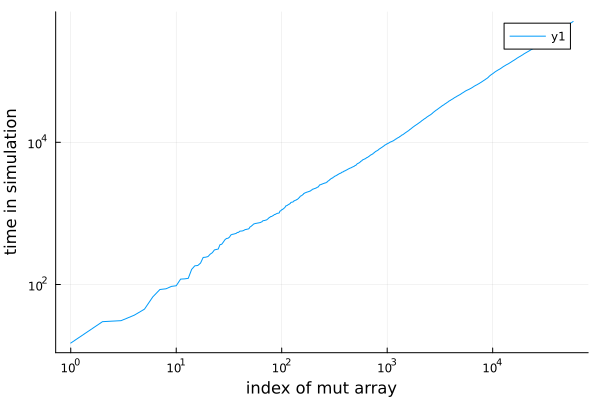

In [39]:
plot(data[:,4], xlabel= "index of mut array", 
    ylabel="time in simulation", xscale =:log10, yscale =:log10)

In [40]:
start_t = 10000
n_muts = 5000
lag = 3
window = 5000
each_step = start_t:lag:(start_t-1)+(lag*n_muts)
println(length(each_step))
println(each_step)


@time y = cont_entr_setofmuts_eachstep(h, J, matrices, mut_times, 
    mut_sites, data[:,2], data[:,3], window, each_step)
;

5000
10000:3:24997
 42.690947 seconds (180.59 M allocations: 28.266 GiB, 10.92% gc time, 0.51% compilation time)


In [41]:
mut_data = data[each_step,:]
using CSV
CSV.write("../data/figures/suppl_data_fig3/cont_entr_df.csv", mut_data)
;

In [42]:
x = 2:window-49
cont = y[:, 50:window-1]
entren = y[:, window+2:end-50]
;

In [43]:
@time writedlm("../data/figures/suppl_data_fig3/cont", cont)

 11.993858 seconds (49.58 M allocations: 10.581 GiB, 15.20% gc time, 0.31% compilation time)


In [44]:
@time writedlm("../data/figures/suppl_data_fig3/entren", entren)

 11.590080 seconds (49.55 M allocations: 10.579 GiB, 13.45% gc time)


In [45]:
@time writedlm("../data/figures/suppl_data_fig3/x_steps", x)

  0.031341 seconds (24.97 k allocations: 1.513 MiB, 93.10% compilation time)


In [226]:
wt = aac_amino_seq
file_aac2 = "../data_matteo/alignments/experimental/AAC/AAC6_A2_pfam117.fasta"
file_aac4 = "../data_matteo/alignments/experimental/AAC/AAC6_A4_pfam117.fasta"
file_aac8 = "../data_matteo/alignments/experimental/AAC/AAC6_A8_pfam117.fasta"
z_aac = [Int8.(fasta2matrix(file_aac2)'), Int8.(fasta2matrix(file_aac4)'),
        Int8.(fasta2matrix(file_aac8)')]
L = length(wt)
f_aac = [reshape(compute_weighted_frequencies(z, 0.)[1], (20, L)) for z in z_aac]
wt_idx_aac = [(wt[i],i) for i in 1:length(wt)]
d_aac = [mean(count_muts_msa(msa', wt)) for msa in z_aac]
;

θ = 0.0 threshold = 0.0
M = 135330 N = 117 Meff = 135330
θ = 0.0 threshold = 0.0
M = 182960 N = 117 Meff = 182960
θ = 0.0 threshold = 0.0
M = 1260048 N = 117 Meff = 1260048


In [268]:
wt = aac_amino_seq
tresh = 0.005:0.005:0.05
@time m_C_AAC = hcat([get_exp_cont(f_aac, wt, wt_idx_aac, t, h_aac, J_aac) 
        for t in tresh]...)
;

Selecting muts with f > 0.005
Number of muts Any[216, 25, 248]
Selecting muts with f > 0.01
Number of muts Any[119, 51, 143]
Selecting muts with f > 0.015
Number of muts Any[77, 42, 109]
Selecting muts with f > 0.02
Number of muts Any[45, 48, 80]
Selecting muts with f > 0.025
Number of muts Any[24, 43, 65]
Selecting muts with f > 0.03
Number of muts Any[8, 42, 49]
Selecting muts with f > 0.035
Number of muts Any[3, 29, 52]
Selecting muts with f > 0.04
Number of muts Any[1, 22, 43]
Selecting muts with f > 0.045
Number of muts Any[1, 12, 43]
Selecting muts with f > 0.05
Number of muts Any[0, 9, 37]
  3.048205 seconds (509.09 k allocations: 21.133 MiB)


In [263]:
tresh = 0.005:0.005:0.05

0.005:0.005:0.05

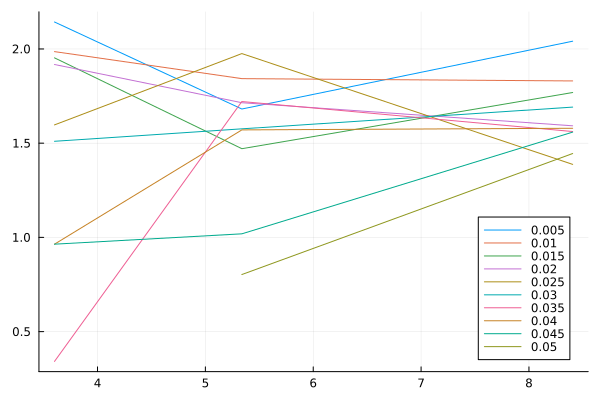

In [271]:
p = plot()
for i in 1:10
    t = tresh[i]
    plot!(p, d_aac, m_C_AAC[:,i], label =" $(t)")
end
display(p)

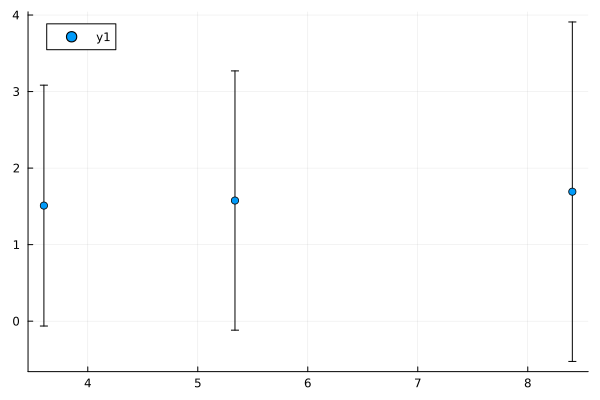

In [247]:
tresh = 0.03
wt = aac_amino_seq
m_C_AAC, st_C_AAC = get_exp_cont_with_std(f_aac, wt, wt_idx_aac, 
    tresh, h_aac, J_aac)
scatter(d_aac, m_C_AAC, yerr = st_C_AAC)


In [248]:
tresh = 0.005:0.005:0.05
n_aac = number_of_seqs(z_aac, f_aac, tresh, wt_idx_aac)
;

(0.005, 680)
(0.01, 1368)
(0.015, 2061)
(0.02, 2709)
(0.025, 3489)
(0.03, 4263)
(0.035, 4818)
(0.04, 6160)
(0.045, 6160)


LoadError: MethodError: reducing over an empty collection is not allowed; consider supplying `init` to the reducer

In [255]:
tresh = 0.005:0.005:0.05
n_aac = 100
wt = aac_amino_seq
@time m_E_AAC  = hcat([give_exp_entren(f_aac, z_aac, n_seqs, wt,
        t, h_aac, J_aac) for t in tresh]...)
;

Number of common muts at treshold 0.005 298
Number of common muts at treshold 0.01 209
Number of common muts at treshold 0.015 171
Number of common muts at treshold 0.02 146
Number of common muts at treshold 0.025 129
Number of common muts at treshold 0.03 114
Number of common muts at treshold 0.035 109
Number of common muts at treshold 0.04 107
Number of common muts at treshold 0.045 107
Number of common muts at treshold 0.05 106
701.161897 seconds (34.67 M allocations: 183.449 GiB, 4.09% gc time)


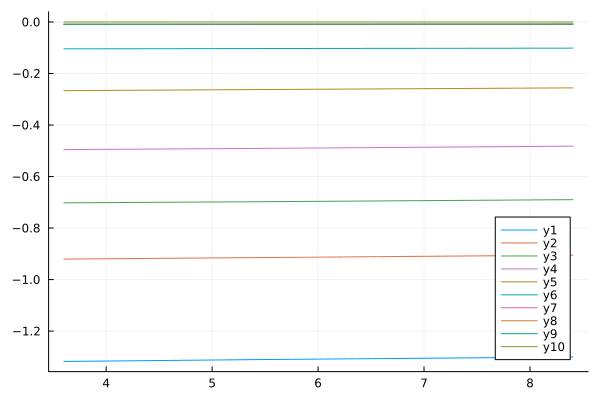

In [256]:
plot(d_aac, m_E_AAC)

Number of common muts at treshold 0.03 114
 68.956797 seconds (2.60 M allocations: 17.879 GiB, 3.66% gc time)


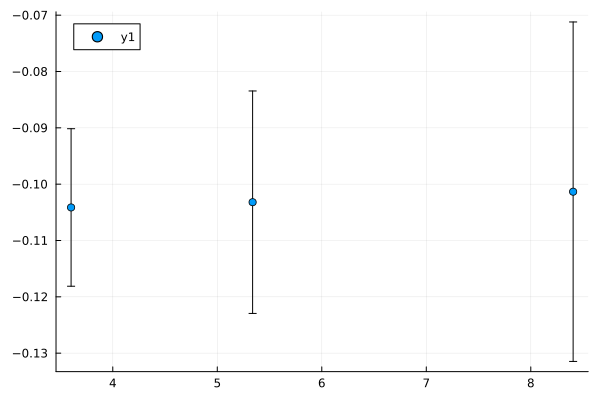

In [253]:
tresh = 0.03
n_seqs = 500
wt = aac_amino_seq
@time single_m_E_AAC, st_E_AAC = give_exp_entren_with_std(f_aac, z_aac, n_seqs, wt,
        tresh, h_aac, J_aac)
scatter(d_aac, single_m_E_AAC, yerr = st_E_AAC)


In [ ]:
### scatter frequency of mutations versus effect of mutation in the context

In [ ]:
#check_exp_muts_in_wt(mut_list, wt, h, J)